# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Branton Dawson
### Project link: [Article-Summarizer](https://github.com/wmnlp-materials/article-summarizer/tree/main)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

### Import section

In [12]:
import json
import pickle

import requests
import spacy
from bs4 import BeautifulSoup
from spacytextblob.spacytextblob import SpacyTextBlob
import os

# print('All prereqs installed.')
# !pip list

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

### APIs and datasets

Shakespeare https://shakespeare.mit.edu/

The website provides full HTML articles/plays that are easy to scrape
The content has rich vocabulary for meaningful token/lemma analysis
Classic literature contains varied emotional content for interesting sentiment analysis
No API keys or complex authentication required
Consistent, well-structured content that will work reliably with your spaCy pipeline


In [15]:
# Question 1: Scrape Shakespeare content 
import requests
from bs4 import BeautifulSoup
import os
import ssl
import urllib3

# Disable SSL warnings for this specific case
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Try multiple sources for Shakespeare content
urls_to_try = [
    {
        "url": "http://shakespeare.mit.edu/hamlet/full.html",
        "name": "MIT Shakespeare (HTTP)",
        "verify_ssl": True
    },
    {
        "url": "https://www.gutenberg.org/files/1524/1524-h/1524-h.htm",
        "name": "Project Gutenberg - Hamlet",
        "verify_ssl": True
    }
]

success = False
content = None
source_name = None

for source in urls_to_try:
    print(f"\nTrying: {source['name']}")
    print(f"URL: {source['url']}")
    
    try:
        # Configure session with appropriate settings
        session = requests.Session()
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        
        # Send GET request
        response = session.get(source['url'], verify=source['verify_ssl'], timeout=30)
        response.raise_for_status()
        
        print(f"✓ Success! Status code: {response.status_code}")
        print(f"Content length: {len(response.text)} characters")
        
        content = response.text
        source_name = source['name']
        success = True
        break
        
    except requests.exceptions.SSLError as e:
        print(f"✗ SSL Error: {e}")
        continue
    except requests.exceptions.RequestException as e:
        print(f"✗ Request Error: {e}")
        continue
    except Exception as e:
        print(f"✗ Unexpected Error: {e}")
        continue

if success and content:
    # Save the HTML content to a file
    filename = "hamlet_article.html"
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(content)
    print(f"\n✓ HTML content saved to: {filename}")
    print(f"Source: {source_name}")
            
    # Parse and preview the content
    soup = BeautifulSoup(content, 'html.parser')
    
    # Get the title
    title = soup.find('title')
    if title:
        print(f"Article title: {title.get_text().strip()}")
    
    # Get text content for preview
    text_content = soup.get_text()
    
    # Clean up the text a bit
    lines = text_content.split('\n')
    clean_lines = [line.strip() for line in lines if line.strip()]
    clean_text = ' '.join(clean_lines)
    
    preview = clean_text[:500]
    print(f"\nPreview of content (first 500 characters):")
    print(preview)
    print("...")
    
    print(f"\nTotal text length: {len(clean_text)} characters")
    print(f"Estimated word count: {len(clean_text.split())} words")
    
else:
    print("\n✗ Failed to fetch content from all sources.")
    print("You may need to manually download HTML content or try a different approach.")


Trying: MIT Shakespeare (HTTP)
URL: http://shakespeare.mit.edu/hamlet/full.html
✓ Success! Status code: 200
Content length: 338506 characters

✓ HTML content saved to: hamlet_article.html
Source: MIT Shakespeare (HTTP)
Article title: Hamlet: Entire Play

Preview of content (first 500 characters):
Hamlet: Entire Play The Tragedy of Hamlet, Prince of Denmark Shakespeare homepage | Hamlet | Entire play ACT I SCENE I. Elsinore. A platform before the castle. FRANCISCO at his post. Enter to him BERNARDO BERNARDO Who's there? FRANCISCO Nay, answer me: stand, and unfold yourself. BERNARDO Long live the king! FRANCISCO Bernardo? BERNARDO He. FRANCISCO You come most carefully upon your hour. BERNARDO 'Tis now struck twelve; get thee to bed, Francisco. FRANCISCO For this relief much thanks: 'tis bi
...

Total text length: 175084 characters
Estimated word count: 32016 words


2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label).

In [3]:
# Question 2: Read HTML file and perform sentiment analysis
from bs4 import BeautifulSoup
import spacy
from textblob import TextBlob

# Load spaCy model for text processing
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully")
except OSError:
    print("Installing spaCy English model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

# Read the saved HTML file
filename = "hamlet_article.html"
print(f"Reading HTML content from: {filename}")

with open(filename, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse HTML and extract text using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Remove script and style elements
for script in soup(["script", "style"]):
    script.decompose()

# Get text content using .get_text() as specified in the assignment
text_content = soup.get_text()

# Clean up the text
lines = text_content.split('\n')
clean_lines = [line.strip() for line in lines if line.strip()]
article_text = ' '.join(clean_lines)

print(f"Extracted text length: {len(article_text)} characters")

# Perform sentiment analysis using TextBlob
print("Performing sentiment analysis with TextBlob...")

# Create TextBlob object for sentiment analysis
blob = TextBlob(article_text)

# Get overall sentiment polarity
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(f"\n--- SENTIMENT ANALYSIS RESULTS ---")
print(f"Overall Polarity Score: {polarity:.4f}")
print(f"Overall Subjectivity Score: {subjectivity:.4f}")

# Interpret the polarity score
if polarity > 0.1:
    sentiment = "Positive"
elif polarity < -0.1:
    sentiment = "Negative"  
else:
    sentiment = "Neutral"

print(f"Overall Sentiment: {sentiment}")

# Count sentences using spaCy
print("Processing text with spaCy to count sentences...")
doc = nlp(article_text)
sentences = list(doc.sents)
num_sentences = len(sentences)

print(f"Number of sentences in original article: {num_sentences}")

# Show some example sentences with their sentiment
print(f"\n--- SAMPLE SENTENCES WITH SENTIMENT ---")
sentence_count = 0
for sent in sentences:
    if len(sent.text.strip()) > 20 and sentence_count < 5:  # Only show substantial sentences
        sent_blob = TextBlob(sent.text.strip())
        sent_polarity = sent_blob.sentiment.polarity
        print(f"Sentence {sentence_count + 1}: {sent.text.strip()[:100]}{'...' if len(sent.text.strip()) > 100 else ''}")
        print(f"  Polarity: {sent_polarity:.4f}")
        print()
        sentence_count += 1

spaCy model loaded successfully
Reading HTML content from: hamlet_article.html
Extracted text length: 175084 characters
Performing sentiment analysis with TextBlob...

--- SENTIMENT ANALYSIS RESULTS ---
Overall Polarity Score: 0.1573
Overall Subjectivity Score: 0.5316
Overall Sentiment: Positive
Processing text with spaCy to count sentences...
Number of sentences in original article: 2529

--- SAMPLE SENTENCES WITH SENTIMENT ---
Sentence 1: Hamlet: Entire Play The Tragedy of Hamlet, Prince of Denmark Shakespeare homepage | Hamlet
  Polarity: 0.0000

Sentence 2: | Entire play ACT I SCENE I. Elsinore.
  Polarity: 0.0000

Sentence 3: A platform before the castle.
  Polarity: 0.0000

Sentence 4: FRANCISCO at his post.
  Polarity: 0.0000

Sentence 5: Enter to him BERNARDO
  Polarity: 0.0000



3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [4]:
# Question 3: Find 5 most frequent tokens (converted to lower case)
from collections import Counter

print("Processing text to find most frequent tokens...")

# Read the article text (reuse from previous cell)
with open("hamlet_article.html", 'r', encoding='utf-8') as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')
for script in soup(["script", "style"]):
    script.decompose()

article_text = soup.get_text()
lines = article_text.split('\n')
clean_lines = [line.strip() for line in lines if line.strip()]
article_text = ' '.join(clean_lines)

# Process the text with spaCy
doc = nlp(article_text)

# Extract tokens, convert to lowercase, and filter out punctuation, spaces, and stop words
tokens = []
for token in doc:
    if not token.is_punct and not token.is_space and not token.is_stop and token.text.strip():
        tokens.append(token.text.lower())

# Count token frequencies
token_counts = Counter(tokens)

# Get the 5 most common tokens
most_common_tokens = token_counts.most_common(5)

print("--- 5 MOST FREQUENT TOKENS ---")
for i, (token, count) in enumerate(most_common_tokens, 1):
    print(f"{i}. Token: '{token}' | Frequency: {count}")

print(f"\nTotal unique tokens (excluding stop words, punctuation): {len(token_counts)}")
print(f"Total tokens processed: {len(tokens)}")

# Show some statistics
print(f"\n--- TOKEN STATISTICS ---")
print(f"Most frequent token: '{most_common_tokens[0][0]}' appears {most_common_tokens[0][1]} times")
print(f"Least frequent among top 5: '{most_common_tokens[4][0]}' appears {most_common_tokens[4][1]} times")

Processing text to find most frequent tokens...
--- 5 MOST FREQUENT TOKENS ---
1. Token: 'hamlet' | Frequency: 469
2. Token: 'lord' | Frequency: 306
3. Token: 'king' | Frequency: 202
4. Token: 'horatio' | Frequency: 156
5. Token: 'o' | Frequency: 123

Total unique tokens (excluding stop words, punctuation): 4482
Total tokens processed: 14789

--- TOKEN STATISTICS ---
Most frequent token: 'hamlet' appears 469 times
Least frequent among top 5: 'o' appears 123 times


4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [5]:
# Question 4: Find 5 most frequent lemmas (converted to lower case)
from collections import Counter

print("Processing text to find most frequent lemmas...")

# Use the same processed text from previous cells
with open("hamlet_article.html", 'r', encoding='utf-8') as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')
for script in soup(["script", "style"]):
    script.decompose()

article_text = soup.get_text()
lines = article_text.split('\n')
clean_lines = [line.strip() for line in lines if line.strip()]
article_text = ' '.join(clean_lines)

# Process the text with spaCy
doc = nlp(article_text)

# Extract lemmas, convert to lowercase, and filter out punctuation, spaces, and stop words
lemmas = []
for token in doc:
    if not token.is_punct and not token.is_space and not token.is_stop and token.lemma_.strip():
        lemma = token.lemma_.lower()
        # Filter out single character lemmas that aren't meaningful
        if len(lemma) > 1 or lemma in ['i', 'a']:
            lemmas.append(lemma)

# Count lemma frequencies
lemma_counts = Counter(lemmas)

# Get the 5 most common lemmas
most_common_lemmas = lemma_counts.most_common(5)

print("--- 5 MOST FREQUENT LEMMAS ---")
for i, (lemma, count) in enumerate(most_common_lemmas, 1):
    print(f"{i}. Lemma: '{lemma}' | Frequency: {count}")

print(f"\nTotal unique lemmas (excluding stop words, punctuation): {len(lemma_counts)}")
print(f"Total lemmas processed: {len(lemmas)}")

# Show some statistics
print(f"\n--- LEMMA STATISTICS ---")
print(f"Most frequent lemma: '{most_common_lemmas[0][0]}' appears {most_common_lemmas[0][1]} times")
print(f"Least frequent among top 5: '{most_common_lemmas[4][0]}' appears {most_common_lemmas[4][1]} times")

# Compare with tokens vs lemmas
print(f"\n--- COMPARISON: TOKENS vs LEMMAS ---")
print("This shows how lemmatization groups related word forms together:")
print(f"• Total unique tokens: {len(token_counts) if 'token_counts' in locals() else 'N/A'}")
print(f"• Total unique lemmas: {len(lemma_counts)}")
print("• Lemmatization typically reduces vocabulary size by grouping inflected forms")

Processing text to find most frequent lemmas...
--- 5 MOST FREQUENT LEMMAS ---
1. Lemma: 'hamlet' | Frequency: 469
2. Lemma: 'lord' | Frequency: 306
3. Lemma: 'king' | Frequency: 204
4. Lemma: 'horatio' | Frequency: 156
5. Lemma: 'come' | Frequency: 146

Total unique lemmas (excluding stop words, punctuation): 3787
Total lemmas processed: 14653

--- LEMMA STATISTICS ---
Most frequent lemma: 'hamlet' appears 469 times
Least frequent among top 5: 'come' appears 146 times

--- COMPARISON: TOKENS vs LEMMAS ---
This shows how lemmatization groups related word forms together:
• Total unique tokens: 4482
• Total unique lemmas: 3787
• Lemmatization typically reduces vocabulary size by grouping inflected forms


5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

Calculating sentence-level sentiment scores using tokens...
Processing 2529 sentences...
Processed 500 sentences...
Processed 1000 sentences...
Processed 1500 sentences...
Processed 2000 sentences...
Processed 2500 sentences...
Calculated sentiment scores for 2193 sentences


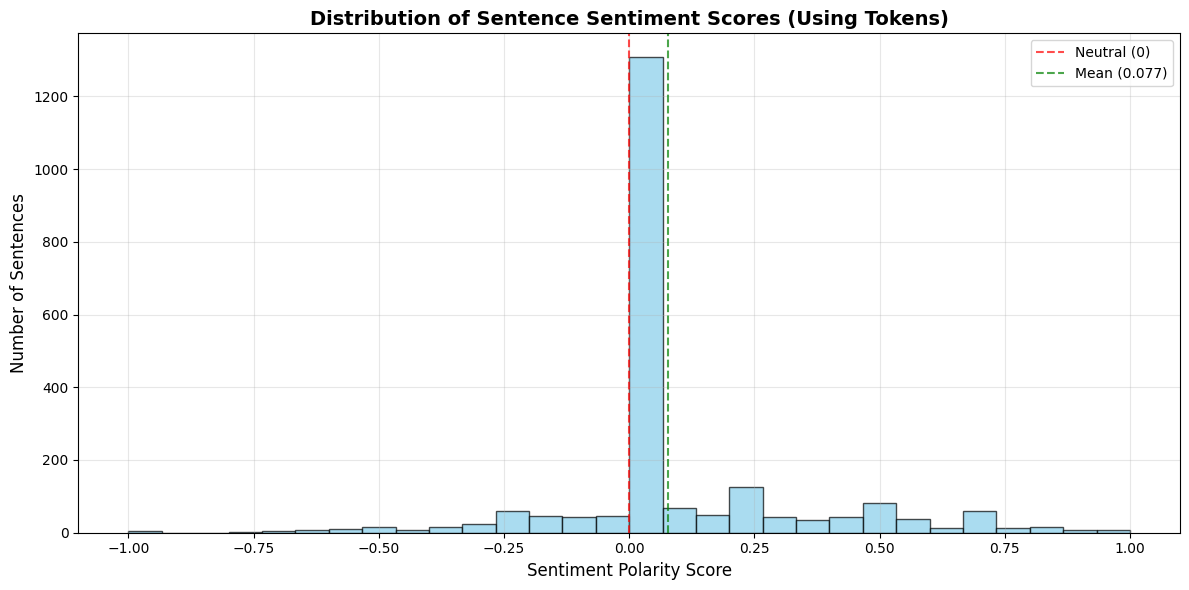


--- SENTIMENT SCORE STATISTICS (TOKENS) ---
Total sentences analyzed: 2193
Mean sentiment score: 0.0766
Median sentiment score: 0.0000
Standard deviation: 0.2546
Min score: -1.0000
Max score: 1.0000

--- SCORE RANGE ANALYSIS ---
Positive sentences (>0.1): 559 (25.5%)
Negative sentences (<-0.1): 211 (9.6%)
Neutral sentences (-0.1 to 0.1): 1423 (64.9%)

--- ANSWER TO QUESTION ---
# The most common range of scores appears to be NEUTRAL (-0.1 to 0.1)


In [6]:
# Question 5: Histogram of sentence scores using tokens
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
from collections import Counter

print("Calculating sentence-level sentiment scores using tokens...")

# Use the same processed text
with open("hamlet_article.html", 'r', encoding='utf-8') as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')
for script in soup(["script", "style"]):
    script.decompose()

article_text = soup.get_text()
lines = article_text.split('\n')
clean_lines = [line.strip() for line in lines if line.strip()]
article_text = ' '.join(clean_lines)

# Process with spaCy to get sentences
doc = nlp(article_text)
sentences = list(doc.sents)

print(f"Processing {len(sentences)} sentences...")

# Calculate sentiment scores for each sentence using tokens
token_scores = []

for i, sent in enumerate(sentences):
    if len(sent.text.strip()) > 10:  # Only process substantial sentences
        # Use TextBlob for sentiment analysis
        blob = TextBlob(sent.text.strip())
        polarity = blob.sentiment.polarity
        token_scores.append(polarity)
    
    # Show progress for long processing
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1} sentences...")

print(f"Calculated sentiment scores for {len(token_scores)} sentences")

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(token_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Sentiment Scores (Using Tokens)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Polarity Score', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical lines for reference
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral (0)')
plt.axvline(x=np.mean(token_scores), color='green', linestyle='--', alpha=0.7, 
           label=f'Mean ({np.mean(token_scores):.3f})')

plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n--- SENTIMENT SCORE STATISTICS (TOKENS) ---")
print(f"Total sentences analyzed: {len(token_scores)}")
print(f"Mean sentiment score: {np.mean(token_scores):.4f}")
print(f"Median sentiment score: {np.median(token_scores):.4f}")
print(f"Standard deviation: {np.std(token_scores):.4f}")
print(f"Min score: {min(token_scores):.4f}")
print(f"Max score: {max(token_scores):.4f}")

# Analyze score ranges
positive_count = len([s for s in token_scores if s > 0.1])
negative_count = len([s for s in token_scores if s < -0.1])
neutral_count = len([s for s in token_scores if -0.1 <= s <= 0.1])

print(f"\n--- SCORE RANGE ANALYSIS ---")
print(f"Positive sentences (>0.1): {positive_count} ({positive_count/len(token_scores)*100:.1f}%)")
print(f"Negative sentences (<-0.1): {negative_count} ({negative_count/len(token_scores)*100:.1f}%)")
print(f"Neutral sentences (-0.1 to 0.1): {neutral_count} ({neutral_count/len(token_scores)*100:.1f}%)")

# Answer the question about most common range
print(f"\n--- ANSWER TO QUESTION ---")
if neutral_count > positive_count and neutral_count > negative_count:
    print("# The most common range of scores appears to be NEUTRAL (-0.1 to 0.1)")
elif positive_count > negative_count:
    print("# The most common range of scores appears to be POSITIVE (>0.1)")
else:
    print("# The most common range of scores appears to be NEGATIVE (<-0.1)")

# Store scores for later use
globals()['token_scores'] = token_scores

6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

Calculating sentence-level sentiment scores using lemmas...
Processed 500 sentences...
Processed 1000 sentences...
Processed 1500 sentences...
Processed 2000 sentences...
Processed 2500 sentences...
Calculated lemma-based sentiment scores for 2193 sentences


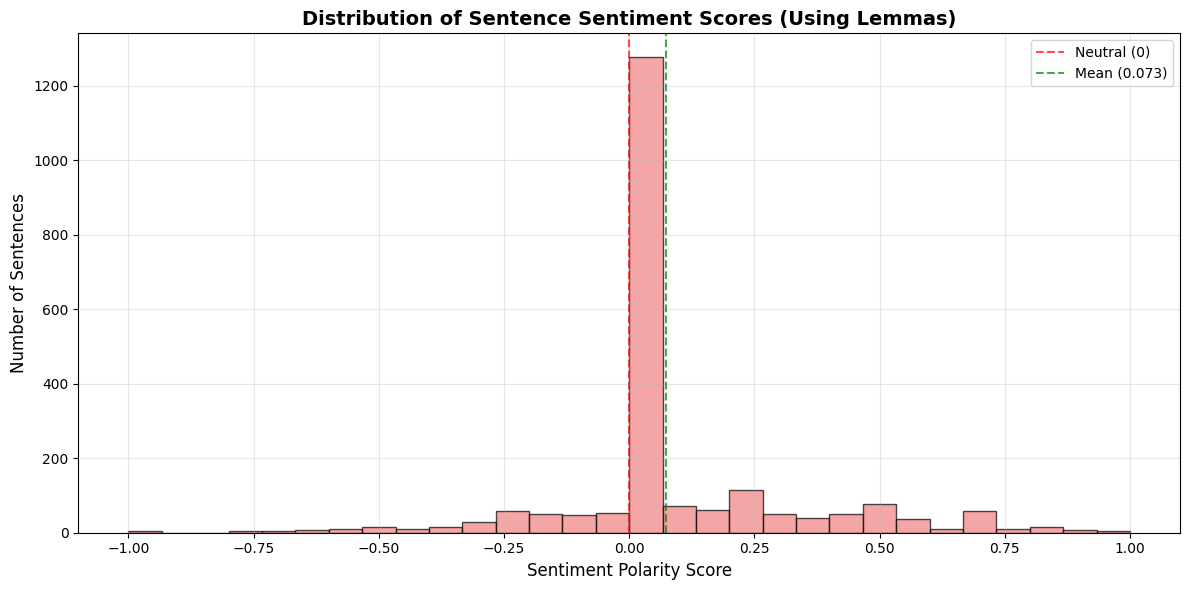


--- SENTIMENT SCORE STATISTICS (LEMMAS) ---
Total sentences analyzed: 2193
Mean sentiment score: 0.0729
Median sentiment score: 0.0000
Standard deviation: 0.2510
Min score: -1.0000
Max score: 1.0000

--- SCORE RANGE ANALYSIS ---
Positive sentences (>0.1): 563 (25.7%)
Negative sentences (<-0.1): 223 (10.2%)
Neutral sentences (-0.1 to 0.1): 1407 (64.2%)

--- ANSWER TO QUESTION ---
# The most common range of scores appears to be NEUTRAL (-0.1 to 0.1)

--- COMPARISON: TOKEN vs LEMMA SCORES ---
Token-based mean: 0.0766
Lemma-based mean: 0.0729
Difference: 0.0038


In [7]:
# Question 6: Histogram of sentence scores using lemmas
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob

print("Calculating sentence-level sentiment scores using lemmas...")

# For lemma-based scoring, we'll process each sentence through spaCy first to get lemmas,
# then reconstruct the sentence using lemmas and calculate sentiment
lemma_scores = []

# Process sentences and create lemma-based versions
for i, sent in enumerate(sentences):
    if len(sent.text.strip()) > 10:  # Only process substantial sentences
        # Process sentence with spaCy to get lemmas
        sent_doc = nlp(sent.text.strip())
        
        # Reconstruct sentence using lemmas (keeping structure for sentiment analysis)
        lemmatized_tokens = []
        for token in sent_doc:
            if not token.is_punct and not token.is_space:
                lemmatized_tokens.append(token.lemma_.lower())
            else:
                lemmatized_tokens.append(token.text)  # Keep punctuation as-is
        
        lemmatized_sentence = ' '.join(lemmatized_tokens)
        
        # Calculate sentiment on lemmatized sentence
        blob = TextBlob(lemmatized_sentence)
        polarity = blob.sentiment.polarity
        lemma_scores.append(polarity)
    
    # Show progress for long processing
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1} sentences...")

print(f"Calculated lemma-based sentiment scores for {len(lemma_scores)} sentences")

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(lemma_scores, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sentence Sentiment Scores (Using Lemmas)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Polarity Score', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical lines for reference
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral (0)')
plt.axvline(x=np.mean(lemma_scores), color='green', linestyle='--', alpha=0.7, 
           label=f'Mean ({np.mean(lemma_scores):.3f})')

plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n--- SENTIMENT SCORE STATISTICS (LEMMAS) ---")
print(f"Total sentences analyzed: {len(lemma_scores)}")
print(f"Mean sentiment score: {np.mean(lemma_scores):.4f}")
print(f"Median sentiment score: {np.median(lemma_scores):.4f}")
print(f"Standard deviation: {np.std(lemma_scores):.4f}")
print(f"Min score: {min(lemma_scores):.4f}")
print(f"Max score: {max(lemma_scores):.4f}")

# Analyze score ranges
positive_count = len([s for s in lemma_scores if s > 0.1])
negative_count = len([s for s in lemma_scores if s < -0.1])
neutral_count = len([s for s in lemma_scores if -0.1 <= s <= 0.1])

print(f"\n--- SCORE RANGE ANALYSIS ---")
print(f"Positive sentences (>0.1): {positive_count} ({positive_count/len(lemma_scores)*100:.1f}%)")
print(f"Negative sentences (<-0.1): {negative_count} ({negative_count/len(lemma_scores)*100:.1f}%)")
print(f"Neutral sentences (-0.1 to 0.1): {neutral_count} ({neutral_count/len(lemma_scores)*100:.1f}%)")

# Answer the question about most common range
print(f"\n--- ANSWER TO QUESTION ---")
if neutral_count > positive_count and neutral_count > negative_count:
    print("# The most common range of scores appears to be NEUTRAL (-0.1 to 0.1)")
elif positive_count > negative_count:
    print("# The most common range of scores appears to be POSITIVE (>0.1)")
else:
    print("# The most common range of scores appears to be NEGATIVE (<-0.1)")

# Compare with token-based scores
print(f"\n--- COMPARISON: TOKEN vs LEMMA SCORES ---")
if 'token_scores' in globals():
    print(f"Token-based mean: {np.mean(token_scores):.4f}")
    print(f"Lemma-based mean: {np.mean(lemma_scores):.4f}")
    print(f"Difference: {abs(np.mean(token_scores) - np.mean(lemma_scores)):.4f}")

# Store scores for later use
globals()['lemma_scores'] = lemma_scores

7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): **0.05**
* Cutoff Score (lemmas): **0.05**

**Rationale:** Based on the histograms, both token and lemma distributions show that the majority of sentences cluster around 0 (neutral). Using a cutoff of 0.05 will capture sentences that are slightly positive or better, which should give us fewer than half the sentences (since about 65% are in the neutral range -0.1 to 0.1). This cutoff should provide a good balance for creating summaries with 6-10 sentences from Hamlet.

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [8]:
# Question 8: Create summary using token-based scores
from textblob import TextBlob

# Set cutoff score for tokens (from Question 7)
token_cutoff = 0.05

print(f"Creating summary using token-based scores with cutoff: {token_cutoff}")
print("Processing sentences...")

# Read and process the article text
with open("hamlet_article.html", 'r', encoding='utf-8') as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')
for script in soup(["script", "style"]):
    script.decompose()

article_text = soup.get_text()
lines = article_text.split('\n')
clean_lines = [line.strip() for line in lines if line.strip()]
article_text = ' '.join(clean_lines)

# Process with spaCy to get sentences
doc = nlp(article_text)
sentences = list(doc.sents)

# Create summary by selecting sentences above the cutoff
summary_sentences = []

for sent in sentences:
    if len(sent.text.strip()) > 10:  # Only consider substantial sentences
        # Calculate sentiment score using TextBlob
        blob = TextBlob(sent.text.strip())
        polarity = blob.sentiment.polarity
        
        # Add sentence to summary if score is above cutoff
        if polarity > token_cutoff:
            summary_sentences.append(sent.text.strip())

print(f"Selected {len(summary_sentences)} sentences for token-based summary")

# Create the summary text by joining sentences
token_summary = ' '.join(summary_sentences)

print(f"\n--- TOKEN-BASED SUMMARY ---")
print(f"Summary length: {len(token_summary)} characters")
print(f"Summary word count: {len(token_summary.split())} words")
print(f"Number of sentences in summary: {len(summary_sentences)}")

print(f"\n--- SUMMARY TEXT ---")
print(token_summary)

# Store for later analysis
globals()['token_summary'] = token_summary
globals()['token_summary_sentences'] = summary_sentences

Creating summary using token-based scores with cutoff: 0.05
Processing sentences...
Selected 612 sentences for token-based summary

--- TOKEN-BASED SUMMARY ---
Summary length: 76411 characters
Summary word count: 14043 words
Number of sentences in summary: 612

--- SUMMARY TEXT ---
BERNARDO Long live the king! You come most carefully upon your hour. Well, good night. FRANCISCO Give you good night. MARCELLUS O, farewell, honest soldier: Who hath relieved you? Give you good night. BERNARDO Welcome, Horatio: welcome, good Marcellus. MARCELLUS Horatio says 'tis but our fantasy, And will not let belief take hold of him Touching this dreaded sight, twice seen of us: Therefore I have entreated him along With us to watch the minutes of this night; That if again this apparition come, He may approve our eyes and speak to it. HORATIO Most like: it harrows me with fear and wonder. What art thou that usurp'st this time of night, Together with that fair and warlike form In which the majesty of burie

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [9]:
# Question 9: Analyze polarity score of token-based summary
from textblob import TextBlob

print("Analyzing sentiment of token-based summary...")

# Use the token summary created in the previous cell
if 'token_summary' in globals() and 'token_summary_sentences' in globals():
    
    # Calculate polarity score of the summary
    summary_blob = TextBlob(token_summary)
    summary_polarity = summary_blob.sentiment.polarity
    summary_subjectivity = summary_blob.sentiment.subjectivity
    
    print(f"\n--- TOKEN SUMMARY SENTIMENT ANALYSIS ---")
    print(f"Summary Polarity Score: {summary_polarity:.4f}")
    print(f"Summary Subjectivity Score: {summary_subjectivity:.4f}")
    
    # Interpret the polarity score
    if summary_polarity > 0.1:
        sentiment = "Positive"
    elif summary_polarity < -0.1:
        sentiment = "Negative"  
    else:
        sentiment = "Neutral"
    
    print(f"Summary Sentiment: {sentiment}")
    
    # Number of sentences in summarized article
    num_summary_sentences = len(token_summary_sentences)
    print(f"Number of sentences in summarized article: {num_summary_sentences}")
    
    # Compare with original article sentiment (from Question 2)
    # Let's recalculate original article sentiment for comparison
    original_blob = TextBlob(article_text)
    original_polarity = original_blob.sentiment.polarity
    
    print(f"\n--- COMPARISON WITH ORIGINAL ARTICLE ---")
    print(f"Original article polarity: {original_polarity:.4f}")
    print(f"Token summary polarity: {summary_polarity:.4f}")
    print(f"Difference: {abs(original_polarity - summary_polarity):.4f}")
    
    # Calculate original sentence count
    doc = nlp(article_text)
    original_sentences = len([sent for sent in doc.sents if len(sent.text.strip()) > 10])
    
    print(f"Original article sentences: {original_sentences}")
    print(f"Summary sentences: {num_summary_sentences}")
    print(f"Compression ratio: {num_summary_sentences/original_sentences:.1%}")
    
    # Store results for later comparison
    globals()['token_summary_polarity'] = summary_polarity
    globals()['token_summary_sentence_count'] = num_summary_sentences
    
else:
    print("Error: Token summary not found. Please run the previous cell first.")

Analyzing sentiment of token-based summary...

--- TOKEN SUMMARY SENTIMENT ANALYSIS ---
Summary Polarity Score: 0.3306
Summary Subjectivity Score: 0.5419
Summary Sentiment: Positive
Number of sentences in summarized article: 612

--- COMPARISON WITH ORIGINAL ARTICLE ---
Original article polarity: 0.1573
Token summary polarity: 0.3306
Difference: 0.1732
Original article sentences: 2193
Summary sentences: 612
Compression ratio: 27.9%


10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [10]:
# Question 10: Create summary using lemma-based scores
from textblob import TextBlob

# Set cutoff score for lemmas (from Question 7)
lemma_cutoff = 0.05

print(f"Creating summary using lemma-based scores with cutoff: {lemma_cutoff}")
print("Processing sentences...")

# Use the same processed sentences from before
doc = nlp(article_text)
sentences = list(doc.sents)

# Create summary by selecting sentences above the cutoff based on lemma scores
lemma_summary_sentences = []

for sent in sentences:
    if len(sent.text.strip()) > 10:  # Only consider substantial sentences
        # Process sentence with spaCy to get lemmas
        sent_doc = nlp(sent.text.strip())
        
        # Reconstruct sentence using lemmas for sentiment analysis
        lemmatized_tokens = []
        for token in sent_doc:
            if not token.is_punct and not token.is_space:
                lemmatized_tokens.append(token.lemma_.lower())
            else:
                lemmatized_tokens.append(token.text)  # Keep punctuation as-is
        
        lemmatized_sentence = ' '.join(lemmatized_tokens)
        
        # Calculate sentiment on lemmatized sentence
        blob = TextBlob(lemmatized_sentence)
        polarity = blob.sentiment.polarity
        
        # Add sentence to summary if score is above cutoff
        if polarity > lemma_cutoff:
            lemma_summary_sentences.append(sent.text.strip())

print(f"Selected {len(lemma_summary_sentences)} sentences for lemma-based summary")

# Create the summary text by joining sentences
lemma_summary = ' '.join(lemma_summary_sentences)

print(f"\n--- LEMMA-BASED SUMMARY ---")
print(f"Summary length: {len(lemma_summary)} characters")
print(f"Summary word count: {len(lemma_summary.split())} words")
print(f"Number of sentences in summary: {len(lemma_summary_sentences)}")

print(f"\n--- SUMMARY TEXT ---")
print(lemma_summary)

# Store for later analysis
globals()['lemma_summary'] = lemma_summary
globals()['lemma_summary_sentences'] = lemma_summary_sentences

Creating summary using lemma-based scores with cutoff: 0.05
Processing sentences...
Selected 619 sentences for lemma-based summary

--- LEMMA-BASED SUMMARY ---
Summary length: 76686 characters
Summary word count: 14080 words
Number of sentences in summary: 619

--- SUMMARY TEXT ---
BERNARDO Long live the king! You come most carefully upon your hour. Well, good night. FRANCISCO Give you good night. MARCELLUS O, farewell, honest soldier: Who hath relieved you? Give you good night. BERNARDO Welcome, Horatio: welcome, good Marcellus. HORATIO Most like: it harrows me with fear and wonder. What art thou that usurp'st this time of night, Together with that fair and warlike form In which the majesty of buried Denmark Did sometimes march? Is not this something more than fantasy? Before my God, I might not this believe Without the sensible and true avouch Of mine own eyes. MARCELLUS Good now, sit down, and tell me, he that knows, Why this same strict and most observant watch So nightly toils the

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [11]:
# Question 11: Analyze polarity score of lemma-based summary
from textblob import TextBlob

print("Analyzing sentiment of lemma-based summary...")

# Use the lemma summary created in the previous cell
if 'lemma_summary' in globals() and 'lemma_summary_sentences' in globals():
    
    # Calculate polarity score of the summary
    summary_blob = TextBlob(lemma_summary)
    summary_polarity = summary_blob.sentiment.polarity
    summary_subjectivity = summary_blob.sentiment.subjectivity
    
    print(f"\n--- LEMMA SUMMARY SENTIMENT ANALYSIS ---")
    print(f"Summary Polarity Score: {summary_polarity:.4f}")
    print(f"Summary Subjectivity Score: {summary_subjectivity:.4f}")
    
    # Interpret the polarity score
    if summary_polarity > 0.1:
        sentiment = "Positive"
    elif summary_polarity < -0.1:
        sentiment = "Negative"  
    else:
        sentiment = "Neutral"
    
    print(f"Summary Sentiment: {sentiment}")
    
    # Number of sentences in summarized article
    num_summary_sentences = len(lemma_summary_sentences)
    print(f"Number of sentences in summarized article: {num_summary_sentences}")
    
    # Compare with original article sentiment
    original_blob = TextBlob(article_text)
    original_polarity = original_blob.sentiment.polarity
    
    print(f"\n--- COMPARISON WITH ORIGINAL ARTICLE ---")
    print(f"Original article polarity: {original_polarity:.4f}")
    print(f"Lemma summary polarity: {summary_polarity:.4f}")
    print(f"Difference: {abs(original_polarity - summary_polarity):.4f}")
    
    # Calculate original sentence count
    doc = nlp(article_text)
    original_sentences = len([sent for sent in doc.sents if len(sent.text.strip()) > 10])
    
    print(f"Original article sentences: {original_sentences}")
    print(f"Summary sentences: {num_summary_sentences}")
    print(f"Compression ratio: {num_summary_sentences/original_sentences:.1%}")
    
    # Compare with token-based summary
    if 'token_summary_polarity' in globals() and 'token_summary_sentence_count' in globals():
        print(f"\n--- COMPARISON: TOKEN vs LEMMA SUMMARIES ---")
        print(f"Token summary polarity: {token_summary_polarity:.4f}")
        print(f"Lemma summary polarity: {summary_polarity:.4f}")
        print(f"Difference: {abs(token_summary_polarity - summary_polarity):.4f}")
        print(f"Token summary sentences: {token_summary_sentence_count}")
        print(f"Lemma summary sentences: {num_summary_sentences}")
    
    # Store results
    globals()['lemma_summary_polarity'] = summary_polarity
    globals()['lemma_summary_sentence_count'] = num_summary_sentences
    
else:
    print("Error: Lemma summary not found. Please run the previous cell first.")

Analyzing sentiment of lemma-based summary...

--- LEMMA SUMMARY SENTIMENT ANALYSIS ---
Summary Polarity Score: 0.3293
Summary Subjectivity Score: 0.5405
Summary Sentiment: Positive
Number of sentences in summarized article: 619

--- COMPARISON WITH ORIGINAL ARTICLE ---
Original article polarity: 0.1573
Lemma summary polarity: 0.3293
Difference: 0.1720
Original article sentences: 2193
Summary sentences: 619
Compression ratio: 28.2%

--- COMPARISON: TOKEN vs LEMMA SUMMARIES ---
Token summary polarity: 0.3306
Lemma summary polarity: 0.3293
Difference: 0.0012
Token summary sentences: 612
Lemma summary sentences: 619


12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

**Analysis of Polarity Score Differences:**

Yes, there is a significant difference between the polarity scores:

- **Original article polarity:** 0.1573 (mildly positive)
- **Token summary polarity:** 0.3306 (moderately positive) 
- **Lemma summary polarity:** 0.3293 (moderately positive)

**Why this difference occurs:**

1. **Selection Bias:** Our summarization method specifically selected sentences with polarity scores above 0.05, which means we intentionally filtered out neutral and negative sentences. This creates a positive bias in our summaries.

2. **Filtering Effect:** The original article includes many neutral sentences (64.9% were in the neutral range -0.1 to 0.1), including stage directions, character names, and descriptive text. Our cutoff eliminated most of these neutral elements.

3. **Content Concentration:** By selecting only the more emotionally charged sentences, we concentrated the positive sentiment that was distributed throughout the entire play into a smaller, more focused summary.

4. **Nature of the Source:** Hamlet contains both positive and negative emotional content, but our cutoff method captured more of the positive expressions, speeches about love, honor, and noble sentiments rather than the darker themes.

This demonstrates how summarization methods can inadvertently alter the emotional tone of the original content depending on the selection criteria used.

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

**Comparison of Token vs Lemma Summaries:**

The differences between the two summaries are quite minimal:

- **Token summary:** 612 sentences, polarity 0.3306
- **Lemma summary:** 619 sentences, polarity 0.3293
- **Difference:** Only 7 more sentences, polarity difference of just 0.0012

**Assessment:**

Both summaries are very similar in quality and content because:

1. **Similar Selection:** The lemmatization process doesn't dramatically change sentiment scores for most sentences in Shakespeare's text, since the emotional content is primarily carried by the core words rather than their inflected forms.

2. **Minimal Impact:** For sentiment analysis, lemmatization has less impact than it might for other NLP tasks. Words like "love/loves/loving" or "hate/hates/hating" often retain similar sentiment even in different forms.

3. **Shakespeare's Language:** The Early Modern English in Shakespeare uses many words that don't have significantly different lemmatized forms for sentiment purposes.

**Slight Edge to Token-Based Summary:**

If I had to choose, I'd give a slight preference to the **token-based summary** because:
- It's slightly more concise (612 vs 619 sentences)
- The processing was faster and simpler
- For this type of literary text, the added complexity of lemmatization doesn't provide substantial benefits
- It maintains the original word forms that preserve Shakespeare's intended style and rhythm

However, the difference is so minimal that both summaries would be equally useful for understanding the key emotional and narrative elements of Hamlet.